<a href="https://colab.research.google.com/github/Satorumi/Machine-Learning/blob/main/Image_Classification_w_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic Image Classification with PyTorch**
Using PyTorch FashionMNIST and apply Neural Networks and Convolutional Networks models.
ref: 
- https://pytorch.org/tutorials/recipes/recipes/defining_a_neural_network.html
- https://youtu.be/GIsg-ZUy0MY

#### Import Dependencies

In [ ]:
import torch
import torchvision
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms 
import torch.onnx as onnx
import torchvision.models as models

Load in Dataset

In [ ]:
# getting train and test data and transform to tensor obj
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor())
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor())


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw




Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
class_name = train_data.classes # the class name
class_index = train_data.class_to_idx # dict contain class_name : index
len(class_name)

10

####Explore and Visualize Dataset

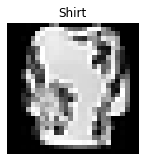

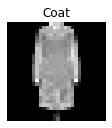

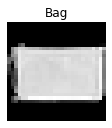

In [ ]:
# display some data
plt.figure(figsize=(8, 8))
for i in range(3):
  sample_idx = torch.randint(len(train_data), size=(1,)).item() # get a random index
  img, label = train_data[sample_idx]
  plt.subplot(1, 3, i+1)
  # pixel range from 0 -1 so use gray cmap
  plt.imshow(img.squeeze(), cmap="gray") # change the img shape
  plt.axis("off")
  plt.title(class_name[label])
  plt.grid(False)
  plt.show()

###Preparing your data for training with DataLoaders

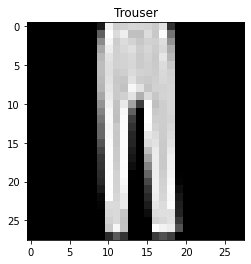

In [ ]:
# using dataloader
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# iter through dataloader obj
train_img, train_labels =  next(iter(train_dataloader))

# display an example from dataloader
img = train_img[0].squeeze()
label = class_name[train_labels[0].item()]
plt.imshow(img, cmap= 'gray')
plt.title(label)
plt.axis('off')
plt.show()

Img Shape

In [ ]:
train_img[0].shape # color channel, width, height

torch.Size([1, 28, 28])

#####Data Augmentation
Randomized data augmentations: We will apply randomly chosen transformations for training dataset

In [ ]:
transformation = transforms.Compose([transforms.RandomCrop(30, padding=4, padding_mode='reflect'),
                transforms.RandomHorizontalFlip()])

In [ ]:
for batch, (imgs, labels) in train_dataloader:
  imgs = transformation(imgs)

###Build and Train Model

#### Neural Network Model
 Define neural network by subclassing nn.Module, and initialize the neural network hidden layers. Every nn.Module subclass implements the operations on input data in the forward method.

In [ ]:
# define a custom model
class NeuralNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten() # input layer to flatten img
    self.Sequential = nn.Sequential(
        nn.Linear(28*28, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, len(class_name)), # output layer with output = len(class)
        nn.ReLU()
    )

  def forward(self, x):
    x = self.flatten(x)
    logits = self.Sequential(x)
    return logits

Get device for Training

In [ ]:
# check if gpu is available, if not not use cpu
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
model = NeuralNetwork().to(device) # use predefined device to train

In [ ]:
model.named_parameters # models parameters

NameError: ignored

Define Hyperparameters

In [ ]:
learning_rate = 1e-3
batch_size = 64
epochs = 12

In [ ]:
loss_function = nn.CrossEntropyLoss()

Optimizer

In [ ]:
# set up SGD optimizer
# pass in model parameters
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Model Training 

In [ ]:
def fit(dataloader, model, loss_function, optimizer):
  data_size = len(dataloader.dataset)
  num_batches = len(dataloader)
  train_loss, correct = 0, 0

  for batch, (features, labels) in enumerate(dataloader):
    pred = model(features) # predict on features
    # compute the loss
    loss = loss_function(pred, labels)

    train_loss += loss_function(pred, labels).item()
    correct += (pred.argmax(1)==labels).type(torch.float).sum().item()

    # backpropagation
    optimizer.zero_grad() # reset grad
    # compute derivative
    loss.backward() 
    optimizer.step()

    if batch % 150 == 0:
      loss, cur_batch = loss.item(), (batch+1) * len(features)
      print(f"Train Loss: {loss:>7f}  [{cur_batch:>5d}/{data_size:>5d}]")

  train_loss = train_loss / num_batches
  accuracy = correct / data_size * 100

  return train_loss, accuracy

def valid(dataloader, model, loss_function):
    data_size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad(): # Disabling Gradient Tracking
      for batch, (features, labels) in enumerate(dataloader):
        pred = model(features)
        # apply loss function
        test_loss += loss_function(pred, labels).item()
        # compute number of correct answer
        correct += (pred.argmax(1)==labels).type(torch.float).sum().item()
        
    
    # compute average loss and accuracy
    test_loss = test_loss / num_batches
    accuracy = correct / data_size * 100 # percent of acc

    print(f'Accuracy: {accuracy:>0.1f}%, Average Test Loss: {test_loss:>8f} \n')
     
    return test_loss, accuracy

In [ ]:
history = {'val loss' : [], 'val acc': [], 'train loss': [], 'train acc': []}
for epoch in range(epochs):
  print(f'Epoch {epoch+1}\n-------------------------------')
  train_loss, train_acc = fit(train_dataloader, model, loss_function, optimizer)
  test_loss, test_acc = valid(test_dataloader, model, loss_function)
  history['val loss'].append(test_loss)
  history['val acc'].append(test_acc)
  history['train loss'].append(train_loss)
  history['train acc'].append(train_acc)

Visualize result

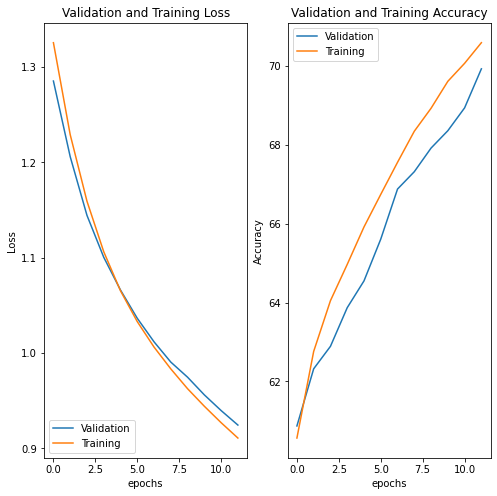

In [ ]:
val_loss = history['val loss']
val_acc = history['val acc']

train_loss = history['train loss']
train_acc = history['train acc']

epoch_range = range(epochs)

plt.figure(figsize=(8,8))

# Loss
plt.subplot(1, 2, 1)
plt.title('Validation and Training Loss')
plt.plot(epoch_range, val_loss)
plt.plot(epoch_range, train_loss)
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['Validation', 'Training'],loc='lower left')

# Accuracy
plt.subplot(1, 2, 2)
plt.title('Validation and Training Accuracy')
plt.plot(epoch_range, val_acc)
plt.plot(epoch_range, train_acc)
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['Validation', 'Training'], loc='upper left')

#### Convolutional Network

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # define conv layers
    # first conv input layers

    self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1), # same padding
            # Batch normalization
            nn.BatchNorm2d(4),
            nn.ReLU(),

            nn.Conv2d(4, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 64, kernel_size=2, stride=1, padding=1),           
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            # residual blocks
            nn.Conv2d(64, 16, 2),
            nn.ReLU(),
            nn.Conv2d(64, 16, 2),
            nn.ReLU(),          
            nn.Dropout2d(0.2),

            nn.Flatten(), # output shape of 64 x 576
            nn.Linear(576, 64),
            nn.ReLU(),
            nn.Linear(64, 10))

  def forward(self, X):
    #X = torch.flatten(X, 1) # flatten all dimensions except batch
    return self.cnn_layers(X)

Define CNN model

In [ ]:
cnn_model = Net()
cnn_model.parameters

<bound method Module.parameters of Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 16, kernel_size=(2, 2), stride=(1, 1))
    (10): Dropout2d(p=0.25, inplace=False)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=576, out_features=64, bias=True)
    (13): ReLU()
    (14): Linear(in_features=64, out_features=10, bias=True)
  )
)>

Define Optimizer, Hyperparameters and Loss function
- **Learning Rate Scheduler**: use a learning rate scheduler, which will change the learning rate after every batch of training
Learn more: https://sgugger.github.io/the-1cycle-policy.html
- **Weight Decay**: regularization technique, prevent weight from exceeding limit by adding additional term to the loss function
Learn more: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab
- **Gradient clipping**: limit the values of gradients to a small range
Learn more: https://towardsdatascience.com/what-is-gradient-clipping-b8e815cdfb48

In [ ]:
# hyperparameters
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
epochs = 12

# define adam optimizer
optimizer = torch.optim.Adam(cnn_model.parameters(), 
                          max_lr, weight_decay=weight_decay)
            
loss_function = nn.CrossEntropyLoss()

# setting an learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, 
                      epochs, steps_per_epochs=len(train_dataloader))

Checking device

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
cnn_model.to(device)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 16, kernel_size=(2, 2), stride=(1, 1))
    (10): Dropout2d(p=0.25, inplace=False)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=576, out_features=64, bias=True)
    (13): ReLU()
    (14): Linear(in_features=64, out_features=10, bias=True)
  )
)

Training Process

In [ ]:
# training function
def fit(dataloader, model, loss_function, optimizer):
  data_size = len(dataloader.dataset)
  num_batches = len(dataloader)
  train_loss, correct = 0, 0
  lrs = [] # keep track of used learning rates

  for batch, (features, labels) in enumerate(dataloader):
    # backpropagation
    optimizer.zero_grad() # reset grad
    
    pred = model(features) # predict on features
    # compute the loss
    loss = loss_function(pred, labels)

    # apply gradient clipping
    nn.utils.clip_grad_value_(model.parameters(), grad_clip)

    # geting train_loss and correct answers
    train_loss += loss.item()
    correct += (pred.argmax(1)==labels).type(torch.float).sum().item()

    
    # compute derivative
    loss.backward() 
    optimizer.step()

    # record and update lr scheduler
    lrs.append(get_lr(optimizer))
    lr_scheduler.step()


    if batch % 150 == 0: # print the current dataset every 150 mini-batches
      loss, cur_batch = loss.item(), (batch+1) * len(features)
      print(f"Train Loss: {loss:>7f}  [{cur_batch:>5d}/{data_size:>5d}]")

  train_loss = train_loss / num_batches
  accuracy = correct / data_size * 100

  return train_loss, accuracy, lrs

# valid function on test set
def valid(dataloader, model, loss_function):
    data_size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad(): # Disabling Gradient Tracking
      for batch, (features, labels) in enumerate(dataloader):
        pred = model(features)
        # apply loss function
        test_loss += loss_function(pred, labels).item()
        # compute number of correct answer
        correct += (pred.argmax(1)==labels).type(torch.float).sum().item()
        
    
    # compute average loss and accuracy
    test_loss = test_loss / num_batches
    accuracy = correct / data_size * 100 # percent of acc

    print(f'Accuracy: {accuracy:>0.1f}%, Average Test Loss: {test_loss:>8f} \n')
     
    return test_loss, accuracy

In [ ]:
history = {'val loss' : [], 'val acc': [], 'train loss': [], 'train acc': []}
for epoch in range(epochs):
  print(f'Epoch {epoch+1}\n-------------------------------')
  train_loss, train_acc = fit(train_dataloader, cnn_model, loss_function, optimizer)
  test_loss, test_acc = valid(test_dataloader, cnn_model, loss_function)
  history['val loss'].append(test_loss)
  history['val acc'].append(test_acc)
  history['train loss'].append(train_loss)
  history['train acc'].append(train_acc)

Epoch 1
-------------------------------
Train Loss: 2.302414  [   64/60000]
Train Loss: 0.928816  [ 9664/60000]
Train Loss: 0.578070  [19264/60000]
Train Loss: 0.694910  [28864/60000]
Train Loss: 0.649428  [38464/60000]
Train Loss: 0.516781  [48064/60000]
Train Loss: 0.388054  [57664/60000]
Accuracy: 80.8%, Average Test Loss: 0.526238 

Epoch 2
-------------------------------
Train Loss: 0.618342  [   64/60000]
Train Loss: 0.260554  [ 9664/60000]
Train Loss: 0.453352  [19264/60000]
Train Loss: 0.624965  [28864/60000]
Train Loss: 0.561555  [38464/60000]
Train Loss: 0.338181  [48064/60000]
Train Loss: 0.377954  [57664/60000]
Accuracy: 82.9%, Average Test Loss: 0.469649 

Epoch 3
-------------------------------
Train Loss: 0.491724  [   64/60000]
Train Loss: 0.349231  [ 9664/60000]
Train Loss: 0.265805  [19264/60000]
Train Loss: 0.429011  [28864/60000]
Train Loss: 0.382899  [38464/60000]
Train Loss: 0.553368  [48064/60000]
Train Loss: 0.428290  [57664/60000]
Accuracy: 84.5%, Average Test 

Visualize Result

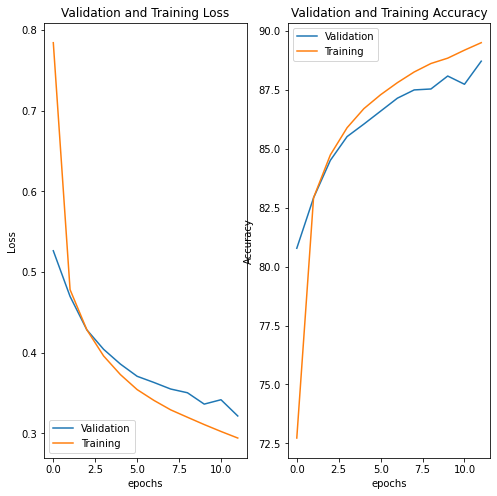

In [ ]:
val_loss = history['val loss']
val_acc = history['val acc']

train_loss = history['train loss']
train_acc = history['train acc']

epoch_range = range(epochs)

plt.figure(figsize=(8,8))

# Loss
plt.subplot(1, 2, 1)
plt.title('Validation and Training Loss')
plt.plot(epoch_range, val_loss)
plt.plot(epoch_range, train_loss)
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend(['Validation', 'Training'],loc='lower left')

# Accuracy
plt.subplot(1, 2, 2)
plt.title('Validation and Training Accuracy')
plt.plot(epoch_range, val_acc)
plt.plot(epoch_range, train_acc)
plt.ylabel('Accuracy')
plt.xlabel('epochs')
plt.legend(['Validation', 'Training'], loc='upper left')

###Save and Load the Model

In [ ]:
torch.save(model.state_dict(), 'mode.pth')
models.load_state_dict(torch.load('model.pth'))
model.eval()